## 1. Introduction

#### 1a. Description
The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution.
#### 1b. Summary
The data is related with <b>direct marketing campaigns of a Portuguese banking institution</b>. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

There are four datasets:

* bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014]
* bank-additional.csv with 10% of the examples (4119), randomly selected from 1), and 20 inputs.
* bank-full.csv with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs).
* bank.csv with 10% of the examples and 17 inputs, randomly selected from 3 (older version of this dataset with less inputs).

The smallest datasets are provided to test more computationally demanding machine learning algorithms (e.g., SVM). Based on data description, <b>bank-additional-full.csv</b> is choosen since it represent all example and 20 inputs. 

#### 1c. Goal
The classification goal is to predict if the client <b>will subscribe</b> (yes/no) a term deposit (variable y).

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV

import logging
import json
import os
import sys
import warnings
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

pd.set_option('display.max_columns', 100)
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

## 2. Exploratory Data Analysis (EDA)

### 2a. bank client column description:
1 - age (numeric)\
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')\
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; <u>note: 'divorced' means divorced or widowed)</u> 
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')\
5 - default: has credit in default? (categorical: 'no','yes','unknown')\
6 - housing: has housing loan? (categorical: 'no','yes','unknown')\
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
#### related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')\
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')\
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')\
<u>11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.</u> 
#### other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)\
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign <u>(numeric; 999 means client was not previously contacted) </u>\
14 - previous: number of contacts performed before this campaign and for this client (numeric)\
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
#### social and economic context attributes
16 - emp.var.rate: [Employment Variation Rate](https://www.quora.com/What-is-meant-by-employment-variation-rate-Does-it-affect-in-any-way-the-financial-decisions-that-an-individual-takes#:~:text=The%20employment%20variation%20rate%2C%20also,Macro%2C%20and%20general%20economics%206y) - quarterly indicator (numeric)\
17 - cons.price.idx: CPI ([Consumer Price Index](https://www.investopedia.com/terms/c/consumerpriceindex.asp)) - monthly indicator (numeric)\
18 - cons.conf.idx: CCI ([Consumer Confidence Index](https://www.investopedia.com/terms/c/cci.asp)) - monthly indicator (numeric)\
19 - euribor3m: EURIBOR ([Euro Interbank Offer Rate](https://www.investopedia.com/terms/e/euribor.asp))  3 month rate - daily indicator (numeric)\
20 - nr.employed: number of employees - quarterly indicator (numeric)
#### Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

In [2]:
bank_raw = pd.read_csv('D:/Kuliah/semester_3/kecerdasan_buatan/Pertemuan_2/data-society-bank-marketing-data/bank-additional-full.csv',delimiter=';')
bank_raw.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  duration  campaign  pdays  previous     poutcome  \
0   may         mon       261         1    999         0  nonexistent   
1   may         mon       149         1    999         0  nonexistent   
2   may         mon       226         1    999         0  nonexistent   
3   may         mon       151         1    999         0  nonexistent   
4   may         mon       307         1    999         0  nonexistent   

   emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0           1.1          93.994          -36.4      4.857       5191.0  no  
1           1.1          93.994          -36.4      4.857       5191.0  no  
2           1.1          93.994          -36.4      4.857       5191.0  no  
3           1.1          93.994          -36.4      4.857       5191.0  no  
4           1.1          93.994          -36.4      4.857       5191.0  no

The table schema is correctly inferred

In [3]:
bank_raw.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

#### 2b. Descriptive Statistics 
From the statistic descriptive, we knew that data consist of 41188 records and described below:

1. Age averaging in 40 years old, with min 17 years old and max 98 years old.
2. The most frequently job appear is admin with 10422 occurence.
3. The most frequently marital status appear is married with 24928 occurence.
4. The most frequently education level appear is university degree with 12168 occurence.
5. Majority has no credit in default with 32588 occurence.
6. Majority still has housing loan with 21576 occurence.
7. Majority has no personal loan with 33950 occurence.
8. Majority is contacted via cellular with 26144 occurence.
9. Majority has last contacted in may with 26144 occurence.
10. Mostly client contacted at Thursday with 8623 occurence.
11. Duration of calls averaging in 258.29 second, but we wont use this feature since its strongly correlated with y.
12. Client commonly contacted 2 to 3 times within campaign period, with min 1 and max 56.
13. Majority client are not contacted from previous marketing campaign, and client that has been contacted previously having average of 6 days after previous marketing campaign with min 0 and max 27.
14. From previous campaign, client having average of being 1 or 2 times contacted, with min 1 and max 7.
15. From previous campaign, the outcome is most likely failure with 4252 occurence from total 5625 occurence.
16. Employee Variation Rate averaging in 0.081886 with min -3.400000 and max 1.400000 (quarterly basis). 
17. Consumer Price Index (CPI) averaging in 93.575664 with min 92.201000 and max 94.767000 (monthly basis).
18. Consumer Confidence Index (CCI) averaging in -40.502600 with min -50.800000 max -26.900000 (monthly basis).
19. Euro Interbank Offer Rate (EURIBOR) averaging in 3.621291 with min 0.634000 and max 5.045000 (3 months rate-daily basis).
20. Number of Employess averaging in 5167 with min 4964 and max 5228 (quarterly basis).
21. The outcome has imbalance class with no response accounted for 36548 occurence.

In [4]:
print(bank_raw.describe(include='all'))

                age     job  marital          education default housing  \
count   41188.00000   41188    41188              41188   41188   41188   
unique          NaN      12        4                  8       3       3   
top             NaN  admin.  married  university.degree      no     yes   
freq            NaN   10422    24928              12168   32588   21576   
mean       40.02406     NaN      NaN                NaN     NaN     NaN   
std        10.42125     NaN      NaN                NaN     NaN     NaN   
min        17.00000     NaN      NaN                NaN     NaN     NaN   
25%        32.00000     NaN      NaN                NaN     NaN     NaN   
50%        38.00000     NaN      NaN                NaN     NaN     NaN   
75%        47.00000     NaN      NaN                NaN     NaN     NaN   
max        98.00000     NaN      NaN                NaN     NaN     NaN   

         loan   contact  month day_of_week      duration      campaign  \
count   41188     41188  

In [5]:
print("how many days after previous marketing campaign")
print(bank_raw[bank_raw['pdays'] != 999]['pdays'].describe())
print()
print("how about client that has not been contacted before")
print(bank_raw[bank_raw['pdays'] == 999]['pdays'].describe())

how many days after previous marketing campaign
count    1515.000000
mean        6.014521
std         3.824906
min         0.000000
25%         3.000000
50%         6.000000
75%         7.000000
max        27.000000
Name: pdays, dtype: float64

how about client that has not been contacted before
count    39673.0
mean       999.0
std          0.0
min        999.0
25%        999.0
50%        999.0
75%        999.0
max        999.0
Name: pdays, dtype: float64


In [6]:
print("how many times client is contacted from previous campaign")
print(bank_raw[bank_raw['pdays'] != 999]['previous'].describe())

how many times client is contacted from previous campaign
count    1515.000000
mean        1.660726
std         0.934306
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         7.000000
Name: previous, dtype: float64


In [7]:
print("from previous campaign, how is the outcome?")
print(bank_raw[bank_raw['poutcome'] != 'nonexistent']['poutcome'].describe())

from previous campaign, how is the outcome?
count        5625
unique          2
top       failure
freq         4252
Name: poutcome, dtype: object


#### 2c. Barchart for Categorical Feature
From barchart created above, several point can be derived:

1. 80% client jobs consist of admin, blue-collars, technician, service, and management.
2. 80% client education consist of university degree and high school.
3. Client that has default loan is much fewer and doesnt fall below 80% of the data. Thus it is highly imbalance.
4. Client that has personal loan is much fewer and doesnt fall below 80% of the data. Thus it is highly imbalance.
5. 80% of client were contacted in may-august.
6. Client is uniformly called during the week.

In [8]:
bank_cat = bank_raw.select_dtypes(include=['object'])
bank_cat.head()

job  marital    education  default housing loan    contact month  \
0  housemaid  married     basic.4y       no      no   no  telephone   may   
1   services  married  high.school  unknown      no   no  telephone   may   
2   services  married  high.school       no     yes   no  telephone   may   
3     admin.  married     basic.6y       no      no   no  telephone   may   
4   services  married  high.school       no      no  yes  telephone   may   

  day_of_week     poutcome   y  
0         mon  nonexistent  no  
1         mon  nonexistent  no  
2         mon  nonexistent  no  
3         mon  nonexistent  no  
4         mon  nonexistent  no

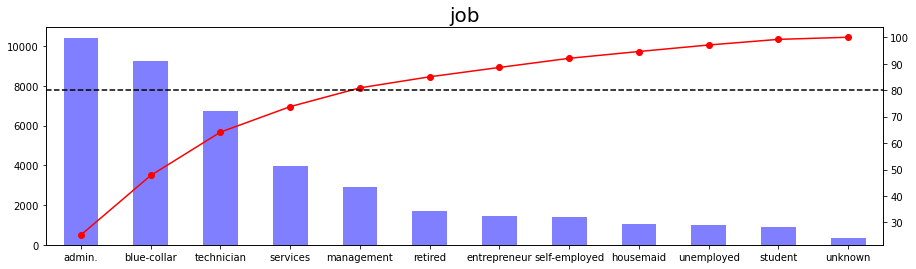

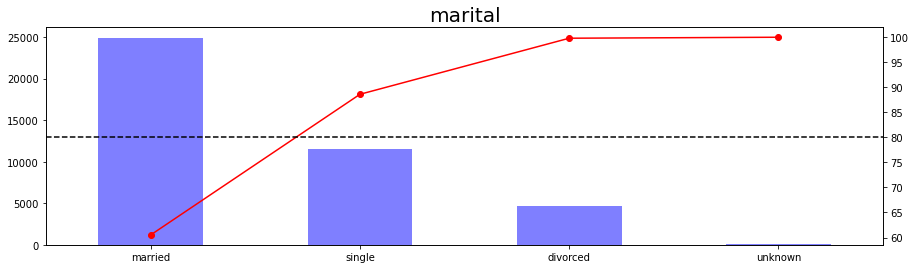

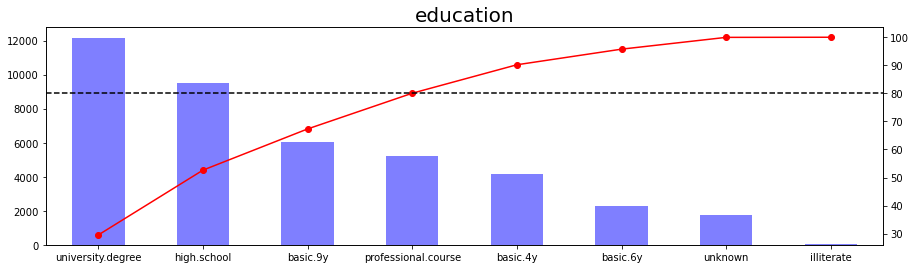

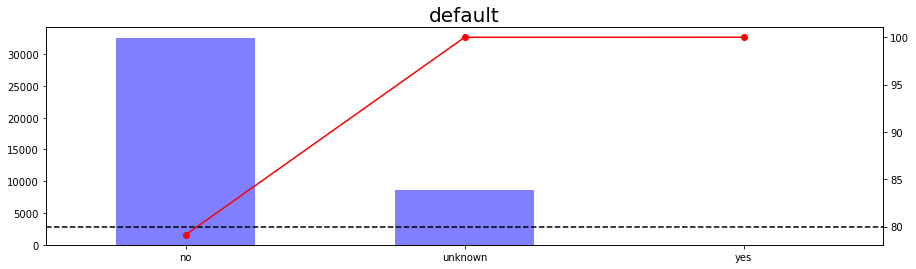

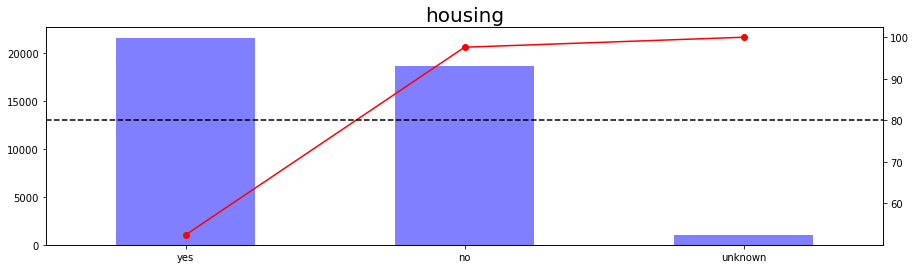

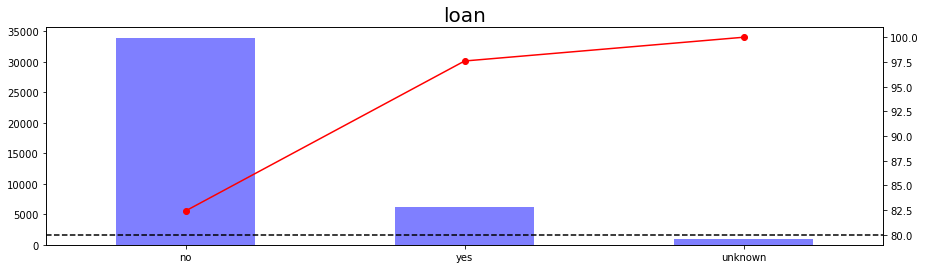

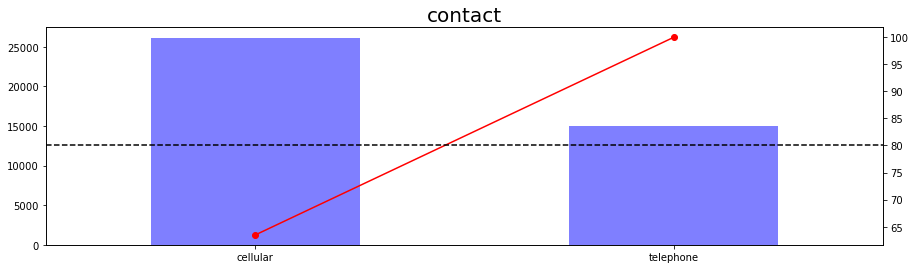

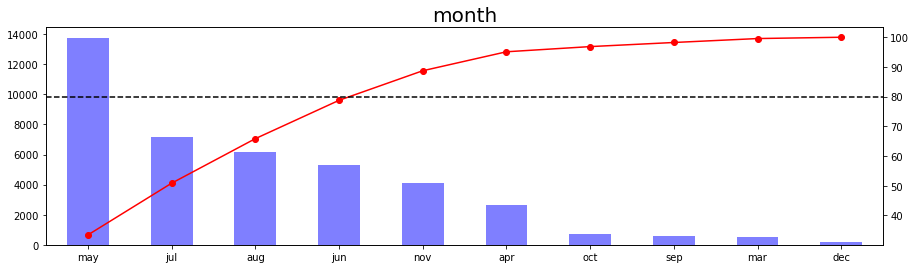

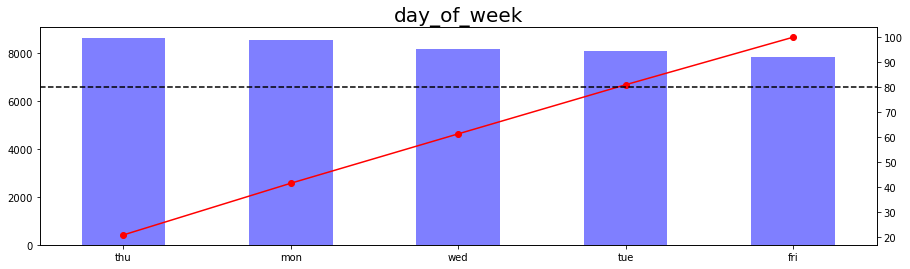

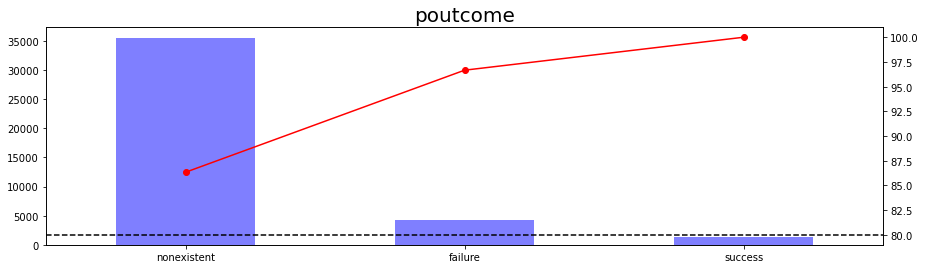

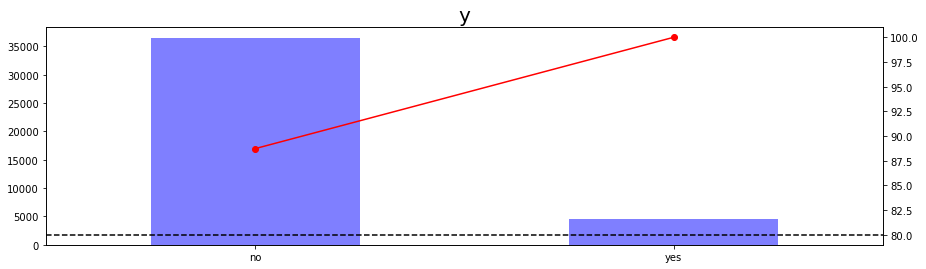

In [9]:
for column in bank_cat:
    plt.figure(figsize=(15,4))
    
    # Calculate value counts and sort by descending order
    value_counts = bank_cat[column].value_counts().sort_values(ascending=False)
    
    # Create bar chart
    value_counts.plot(kind='bar', color='blue', alpha=0.5)
    
    # Calculate cumulative sums and convert to percentage of total
    cumulative_sums = value_counts.cumsum() / value_counts.sum() * 100
    
    # Create Pareto line
    cumulative_sums.plot(kind='line', marker='o', color='red', secondary_y=True)

    # Add dotted line at 80%
    plt.axhline(y=80, color='k', linestyle='--')
    
    plt.title(column, fontdict={'fontsize': 20})
    plt.show()

#### 2c. Boxplot for Numerical Feature
From boxplot created above, several point can be derived:

1. Outliers exist in age, duration, campaign, pdays, previous, and CCI

In [10]:
bank_num = bank_raw.select_dtypes(exclude=['object'])
bank_num.head()

age  duration  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
0   56       261         1    999         0           1.1          93.994   
1   57       149         1    999         0           1.1          93.994   
2   37       226         1    999         0           1.1          93.994   
3   40       151         1    999         0           1.1          93.994   
4   56       307         1    999         0           1.1          93.994   

   cons.conf.idx  euribor3m  nr.employed  
0          -36.4      4.857       5191.0  
1          -36.4      4.857       5191.0  
2          -36.4      4.857       5191.0  
3          -36.4      4.857       5191.0  
4          -36.4      4.857       5191.0

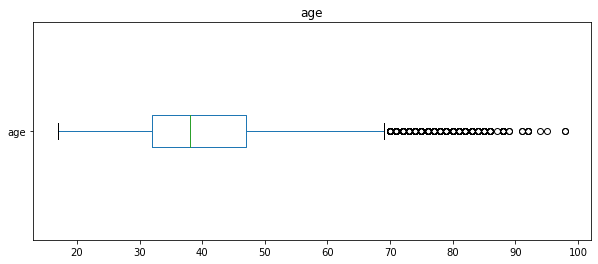

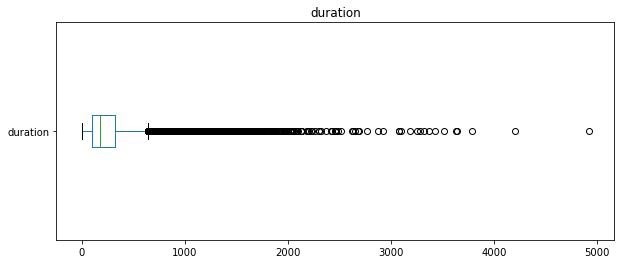

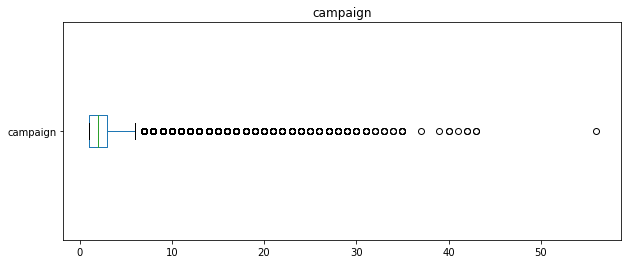

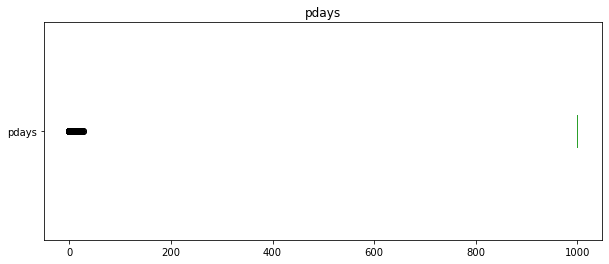

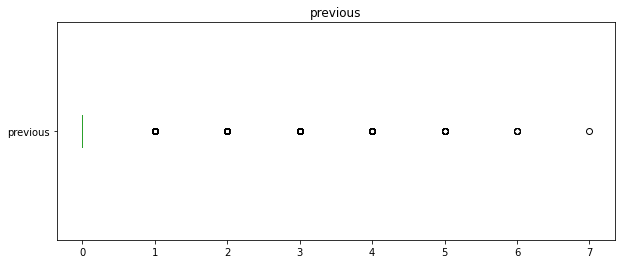

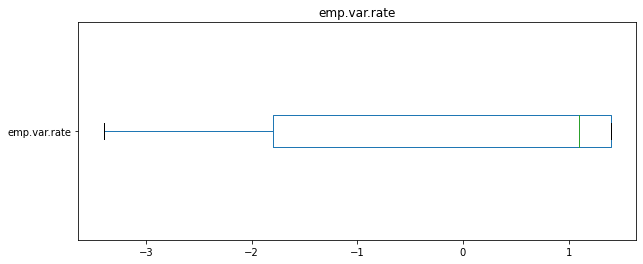

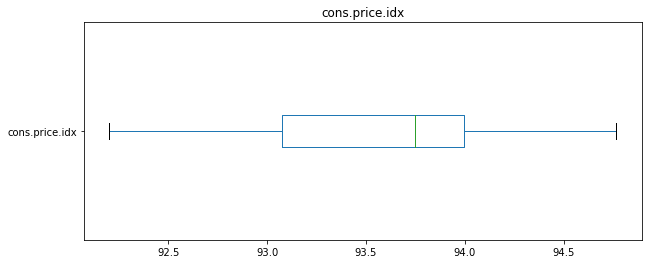

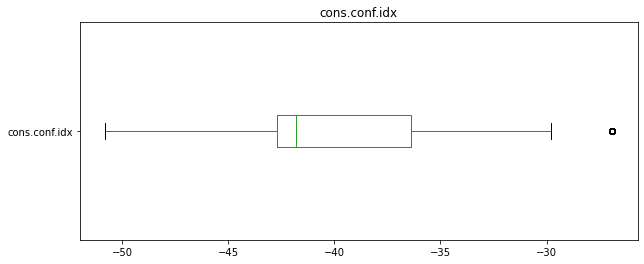

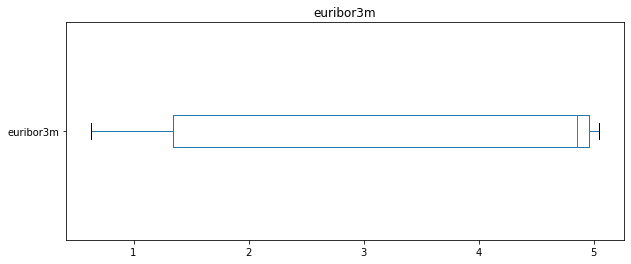

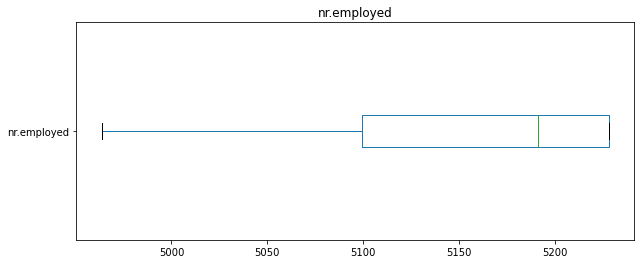

In [11]:
for column in bank_num:
    plt.figure(figsize=(10,4))
    bank_num.boxplot([column], vert=False, grid=False)
    plt.title(column)
    plt.show()

### 3. Data Preprocessing
In this script, Random forest classifier is the proposed model, thus before using it, assumption must be satisfied.  

1. Sampling is representative.
2. Missing value should be handled from training the model.
3. Data should contain some actual values in feature variables.

Note
* There should be keep in mind that a Very unbalanced data in columns may produce bias since most tree may lean towards the biggest data proportion, thus ignoring the others.
* No formal distributional assumptions, random forests are non-parametric and can thus handle skewed and multi-modal data as well as categorical data that are ordinal or non-ordinal.

Reference: \
https://stats.stackexchange.com/questions/59124/random-forest-assumptions \
https://www.simplilearn.com/tutorials/data-science-tutorial/random-forest-in-r \
https://bccvl.org.au/algorithms-exposed-random-forest/

#### 3.1. Sampling is Representative
Stratified sampling is yet used, it potentially used in train_test_split and random forest classifier.

#### 3.2. Check Missing Value
There is no missing value found on bank_raw data, thus second assumption is satisfied

In [12]:
bank_raw.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

#### 3.3. Data Contain Actual Value
The use of raw data represent the actual value, thus third assumption is satisfied

#### 3.4. Data Preparation
a. Remove duration \
b. Label Encoding the dataset \
c. Upsampling minority target \
c. Split dataset into independent and dependent dataset

In [13]:
bank_rm_duration = bank_raw.drop("duration", axis=1)

In [14]:
# Separate features and target
X = bank_rm_duration.drop('y', axis=1)
y = bank_rm_duration['y']

# Create a boolean list indicating which columns are categorical
categorical_features = (X.dtypes == object).tolist()

# Initialize SMOTENC with the correct categorical features
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=0)

# Perform resampling
X_resampled, y_resampled = smote_nc.fit_resample(X, y)

In [15]:
# Perform Dummy Variable Encoding
# This method is similar to one-hot encoding but it drops one dummy variable from the results to avoid multicollinearity, a situation in which two or more variables are highly correlated.
#bank_enc = pd.get_dummies(bank_rm_duration, columns=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome'], drop_first=True)
bank_enc = bank_rm_duration.drop(['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome'], axis=1)
bank_enc['y'] = bank_enc['y'].map({'yes': 1, 'no': 0})


#X_resampled = pd.get_dummies(X_resampled, columns=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome'], drop_first=True)
X_resampled = X_resampled.drop(['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome'], axis=1)
y_resampled = y_resampled.map({'yes': 1, 'no': 0})

In [16]:
X_resampled.head()

age  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
0   56         1    999         0           1.1          93.994   
1   57         1    999         0           1.1          93.994   
2   37         1    999         0           1.1          93.994   
3   40         1    999         0           1.1          93.994   
4   56         1    999         0           1.1          93.994   

   cons.conf.idx  euribor3m  nr.employed  
0          -36.4      4.857       5191.0  
1          -36.4      4.857       5191.0  
2          -36.4      4.857       5191.0  
3          -36.4      4.857       5191.0  
4          -36.4      4.857       5191.0

In [37]:
#X = bank_enc.drop(["y"], axis=1)
#y = bank_enc["y"]
X = X_resampled
y = y_resampled

### 4. Random Forest Classifier

[A random forest classifier.](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.

#### 4.1. Parameter Tunning and Model Training

In [38]:
rand_seed = 123
np.random.seed(rand_seed)

In [39]:
# Assuming X is your feature matrix and y are your labels
# Generate a random sample for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_seed)

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
Best parameters:  {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}

In [20]:
#### Train a Random Forest classifier

#### Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

#### Create a base model
rf = RandomForestClassifier(random_state=rand_seed)

#### Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2)

#### Fit the grid search to the data
grid_search.fit(X_train, y_train)

#### Get the best parameters
best_params = grid_search.best_params_

print("Best parameters: ", best_params)

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
Best parameters:  {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500}


In [40]:
def eval_metrics(actual, pred):
    accuracy = accuracy_score(actual, pred)
    f1 = f1_score(actual, pred)
    recall = recall_score(actual, pred)
    precision = precision_score(actual, pred)
    return accuracy, f1, recall, precision

In [41]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Bank_Marketing")

<Experiment: artifact_location='mlflow-artifacts:/318929191823953936', creation_time=1694958964337, experiment_id='318929191823953936', last_update_time=1694958964337, lifecycle_stage='active', name='Bank_Marketing', tags={}>

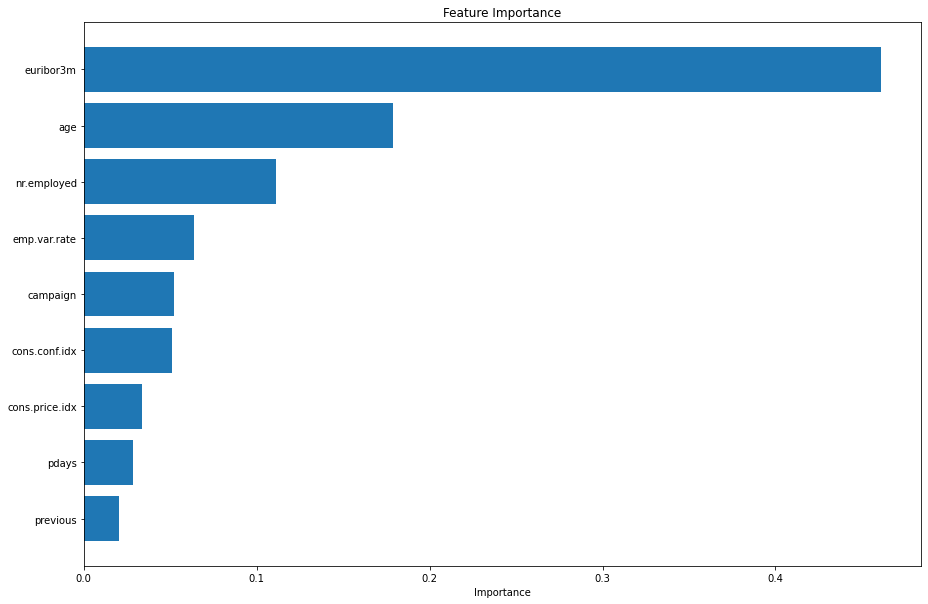

Accuracy: 0.8864569083447332
F1 Score: 0.8856906762153973
Recall: 0.8805970149253731
Precision: 0.8908436071478044


Registered model 'BankMarketing' already exists. Creating a new version of this model...
2023/09/18 00:24:37 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: BankMarketing, version 12
Created version '12' of model 'BankMarketing'.


In [42]:
if __name__ == "__main__":
    warnings.filterwarnings("ignore")
    rand_seed = 123
    np.random.seed(rand_seed)

    # Assuming X is your feature matrix and y are your labels
    # Generate a random sample for training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_seed)

    with mlflow.start_run(run_name="bank_num"):
        clf = RandomForestClassifier(**best_params)
        clf.fit(X_train, y_train)

        # Feature Importance Visualization
        # Assuming clf is your trained model and feature_names is the list of feature names
        feature_importance = clf.feature_importances_
        feature_names = np.array(X.columns)

        # Sort features by importance
        sorted_idx = np.argsort(feature_importance)

        # Create a horizontal bar plot
        plt.figure(figsize=(15,10))
        plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
        plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
        plt.xlabel('Importance')
        plt.title('Feature Importance')

        # Save the figure as a PNG
        if not os.path.exists("images"):
            os.mkdir("images")

        plt.savefig("feature_importance.png")
        plt.show()

    
        # Test Random Forest Classification Model
        y_pred = clf.predict(X_test)

        (accuracy, f1, recall, precision) = eval_metrics(y_test, y_pred)

        print(f"Accuracy: {accuracy}")
        print(f"F1 Score: {f1}")
        print(f"Recall: {recall}")
        print(f"Precision: {precision}")

        mlflow.log_param("accuracy", accuracy)
        mlflow.log_param("f1 score", f1)
        mlflow.log_param("recall", recall)
        mlflow.log_param("precision", precision)
        #mlflow.log_artifact("feature_importance.json")
        mlflow.log_artifact("feature_importance.png")

        predictions = clf.predict(X_train)
        signature = infer_signature(X_train, predictions)
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        # Model registry does not work with file store
        if tracking_url_type_store != "file":
            mlflow.sklearn.log_model(clf, "model", registered_model_name="BankMarketing", signature=signature)
        else:
            mlflow.sklearn.log_model(clf, "model", signature=signature)

    

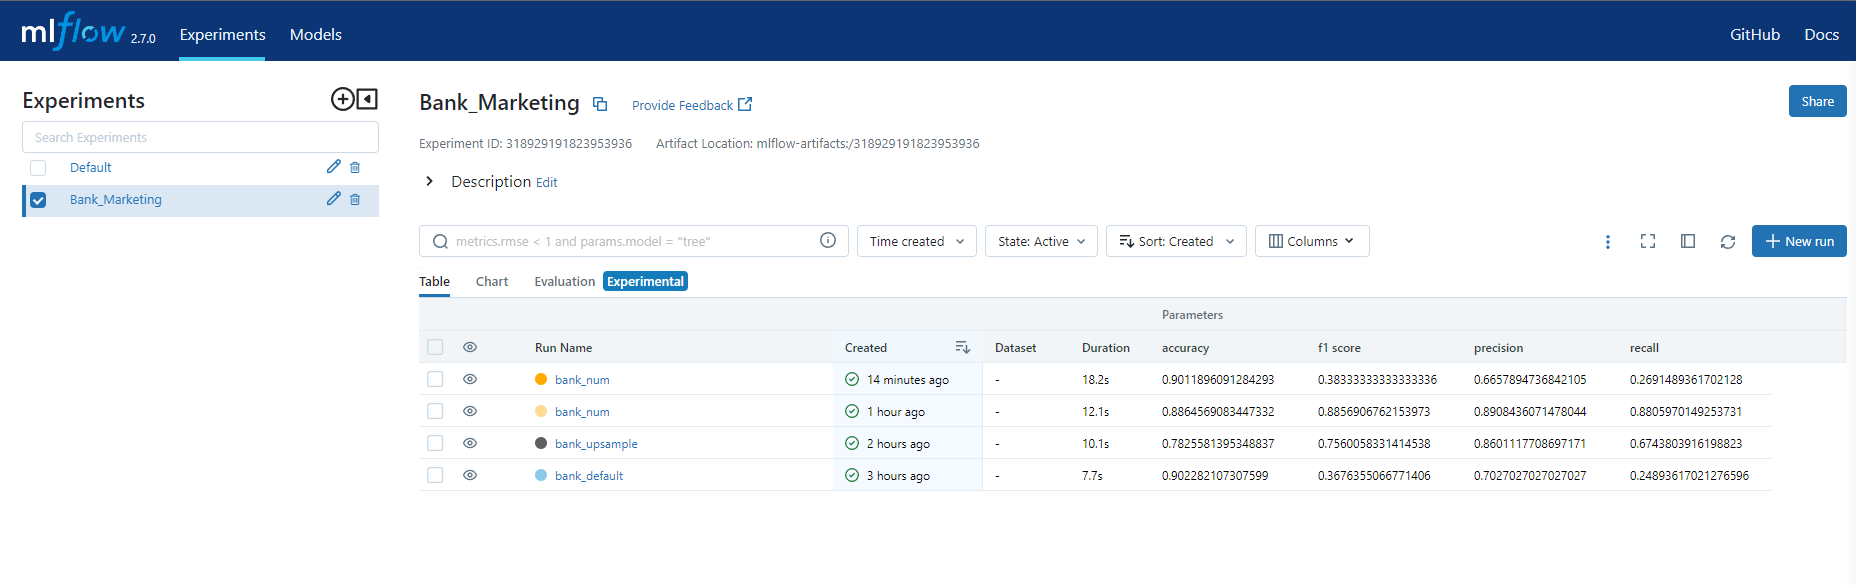

In [43]:
from IPython.display import Image
Image("D:\Kuliah\semester_3\kecerdasan_buatan\Pertemuan_2\data-society-bank-marketing-data\Model_Comparison.png")

#### 4.2. Model Interpretation

Lets learn about how to interpret the metrics

1 - Accuracy is suitable with balanced dataset when there are an equal number of observations in each class which isn’t common in real-life problems.

2 - Precision is important when the cost of false positives is high.

3 - Recall is important when the cost of false negatives is high.

4 - F1 score considers both the precision and recall.

Looking back at case at hand, this dataset related with direct marketing campaigns (via phone calls) of a Portuguese banking institution. The goal is to predict if the client <b>will subscribe</b> (yes/no) a term deposit (variable y). Based on this information, it is assumed that in the campaign, client who likely subscribed and not will undergo different approach. Thus, both predictions are equally important.

#### a. First Training
First attempt is performed using dummy variables. Using this set of parameter {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200} yield:

Accuracy:  0.902282107307599 \
F1 Score:  0.3676355066771406 \
Recall:  0.24893617021276596 \
Precision:  0.7027027027027027 

The recall is very low, thus affecting F1 score also low. This may happen since the model uses imbalance target, lets try upsampling the minor target (no)

#### b. Second Training
Second attempt is performed using dummy variables and SMOTENC upsampling method. Using this set of parameter {'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500} yield:

Accuracy: 0.7825581395348837 \
F1 Score: 0.7560058331414538 \
Recall: 0.6743803916198823 \
Precision: 0.8601117708697171

This result is better than previous attempt since recall value is substantially increased as the result of upsampling using SMOTENC.

#### c. Third Training
Third attemp is performed using only numerical feature on non upsampling data, using this set of parameter {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500} yield:

Accuracy: 0.9011896091284293
F1 Score: 0.38333333333333336
Recall: 0.2691489361702128
Precision: 0.6657894736842105

As expected, using imbalance dataset produce lower recall, thus lowering F1 score which made upsampling method more preferable

#### d. Forth Training
Fourth attemp is performed using only numerical feature on SMOTENC upsampling data, using this set of parameter {'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200} yield:

Accuracy: 0.8864569083447332 \
F1 Score: 0.8856906762153973 \
Recall: 0.8805970149253731 \
Precision: 0.8908436071478044

The performance is considerably better than previous attempt with high F1 Score, therefore this model is able to discriminate outcome (y) better than previous. Thus, this model is selected

Reference: \
https://medium.com/analytics-vidhya/what-precision-recall-f1-score-and-accuracy-can-tell-you-fe1eab1ada5a \
https://datascience.stackexchange.com/questions/105089/how-f1-score-is-good-with-unbalanced-dataset

In [44]:
import plotly.graph_objects as go
import pandas as pd
import os

# Assuming clf is your trained RandomForestClassifier and X is your feature matrix
importances = clf.feature_importances_
features = X.columns

# Create a DataFrame with features and their importances
df_importances = pd.DataFrame({
    'feature': features,
    'importance': importances
})

# Sort the DataFrame in descending order of importance
df_importances = df_importances.sort_values('importance', ascending=False)

# Create a Figure
fig = go.Figure()

# Add a trace for each feature
for _, row in df_importances.iterrows():
    fig.add_trace(go.Bar(x=[row['feature']], y=[row['importance']],
                         hovertemplate='Importance: %{y}<extra></extra>'))

# Set layout properties
fig.update_layout(
    title='Feature Importance',
    xaxis_title='Features',
    yaxis_title='Importance',
    showlegend=False,
    hovermode='x'
)

# Show the figure
fig.show()


In [45]:
avg_feature_importance = np.mean(feature_importance)
avg_feature_importance

0.11111111111111113

The meaning of having high value and low value of importance is as follows:

1. Importance is a measure of how much a feature contributes to the prediction accuracy of a machine learning model.
2. High value of importance means that the feature is very relevant and influential for the model’s performance. Changing or removing the feature would significantly affect the model’s accuracy.
3. Low value of importance means that the feature is not very relevant or influential for the model’s performance. Changing or removing the feature would not significantly affect the model’s accuracy.

In this chart, euribor3m, age, and nr.employed are greater than average importance score (based on heuristic approach). Thus, lets see how this three column characteristics based on target variable. 


Reference: \
https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [46]:
# Convert X_resampled to DataFrame
X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)

# Convert y_resampled to DataFrame
y_resampled_df = pd.DataFrame(y_resampled, columns=['y'])

# Concatenate X_resampled_df and y_resampled_df
resampled_df = pd.concat([X_resampled_df, y_resampled_df], axis=1)

resampled_df.head()

age  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
0   56         1    999         0           1.1          93.994   
1   57         1    999         0           1.1          93.994   
2   37         1    999         0           1.1          93.994   
3   40         1    999         0           1.1          93.994   
4   56         1    999         0           1.1          93.994   

   cons.conf.idx  euribor3m  nr.employed  y  
0          -36.4      4.857       5191.0  0  
1          -36.4      4.857       5191.0  0  
2          -36.4      4.857       5191.0  0  
3          -36.4      4.857       5191.0  0  
4          -36.4      4.857       5191.0  0

In [47]:
resampled_df.groupby('y')['euribor3m'].describe()

count      mean       std    min       25%       50%       75%    max
y                                                                         
0  36548.0  3.811491  1.638187  0.634  1.405000  4.857000  4.962000  5.045
1  36548.0  2.120282  1.743075  0.634  0.847427  1.267079  4.330096  5.045

In [48]:
resampled_df.groupby('y')['age'].describe()

count       mean        std   min   25%   50%   75%   max
y                                                             
0  36548.0  39.911185   9.898132  17.0  32.0  38.0  47.0  95.0
1  36548.0  40.640363  13.761825  17.0  30.0  37.0  49.0  98.0

In [49]:
resampled_df.groupby('y')['nr.employed'].describe()

count         mean        std     min     25%     50%     75%     max
y                                                                         
0  36548.0  5176.166600  64.571979  4963.6  5099.1  5195.8  5228.1  5228.1
1  36548.0  5095.003376  87.609914  4963.6  5017.5  5099.1  5191.0  5228.1

In [50]:
import plotly.express as px
fig = px.scatter_3d(resampled_df, x='euribor3m', y='age', z='nr.employed', color='y')
fig.show()

Based on descriptive statistics and visualization, there is no significant difference between yes and no. Further investigation can be made using class_weight parameter in Random Forest and train_test_split. Thus, the temporary conclusion were in terms of bank marketing case, euribor3m, age, and nr.employed are the biggest factor that affecting whether customer will subscribe or not. Since it is assumed that both positive and negative response is equally importance, the use of F1 score is a good metrics to determine which model is better.